Five Classes Vertical Translation. Bidimensional.
100 batches of 228 instances



METHOD: Static lp as classifier
Execution time:  0.48689644705130797
Average error: 54.22
Average macro-F1: 0.35533072251664505
Average micro-F1: 0.45319999999999994
Acurácia Média:  45.78
Desvio Padrão:  18.855049986674658
Variância:  355.51291000000003


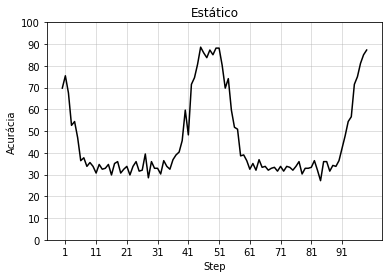

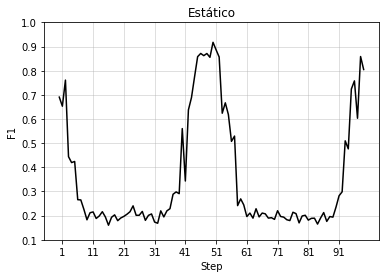




METHOD: Sliding lp as classifier
Execution time:  0.4232974929345036
Average error: 65.7244
Average macro-F1: 0.1143800746494198
Average micro-F1: 0.34559999999999996
Acurácia Média:  34.27559999999999
Desvio Padrão:  5.372223993840913
Variância:  28.860790640000005


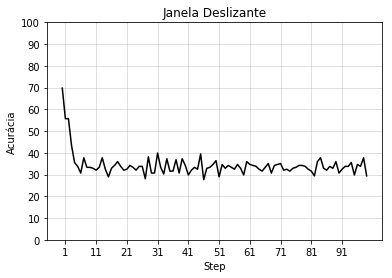

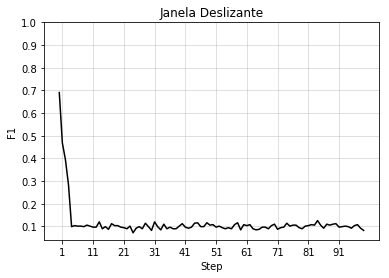




METHOD: Incremental lp as classifier
Execution time:  13.73347270978234
Average error: 54.78180000000001
Average macro-F1: 0.34393431074778513
Average micro-F1: 0.4477999999999999
Acurácia Média:  45.21819999999999
Desvio Padrão:  18.011773004343574
Variância:  324.4239667599999


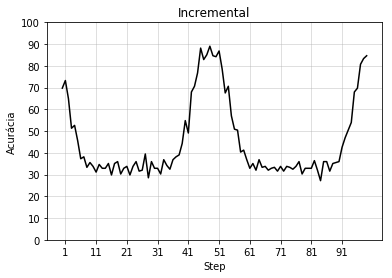

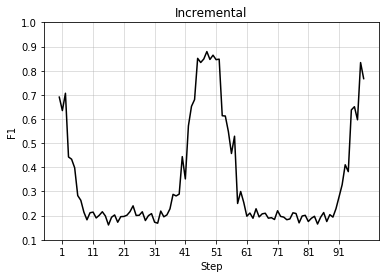




METHOD: lp as classifier and kde as core support extraction with cutting data method
Execution time:  0.8594144260845038
Average error: 58.8812
Average macro-F1: 0.34952301470544733
Average micro-F1: 0.4144
Acurácia Média:  41.1188
Desvio Padrão:  26.000021164606768
Variância:  676.0011005599998


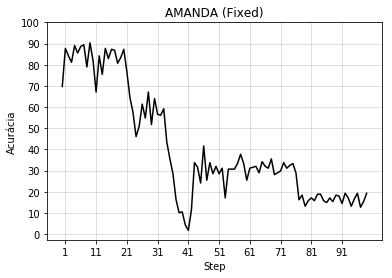

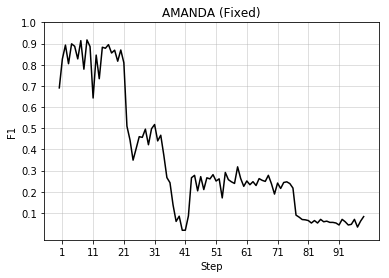




METHOD: lp as classifier and kde and Hellinger distance as dynamic CSE
AMANDA-DCP Hellinger | Mean keeping percentage=0.33 | Std keeping percentage=0.17
Execution time:  0.8935745114022957
Average error: 60.73700000000001
Average macro-F1: 0.1871055387955722
Average micro-F1: 0.3962
Acurácia Média:  39.26299999999999
Desvio Padrão:  12.014659420890798
Variância:  144.35204099999999


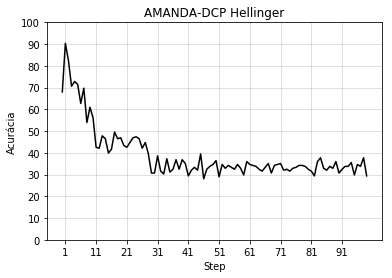

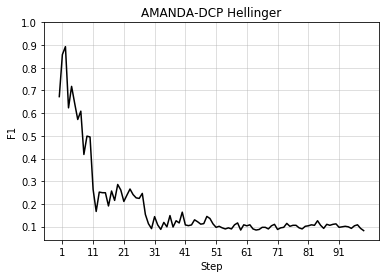




METHOD: lp as classifier and kde and Hellinger2 distance as dynamic CSE
AMANDA-DCP Hellinger2 | Mean keeping percentage=0.27 | Std keeping percentage=0.07
Execution time:  0.9111985203122721
Average error: 68.645
Average macro-F1: 0.2242046007192259
Average micro-F1: 0.3128
Acurácia Média:  31.355000000000004
Desvio Padrão:  18.16518315349449
Variância:  329.973879


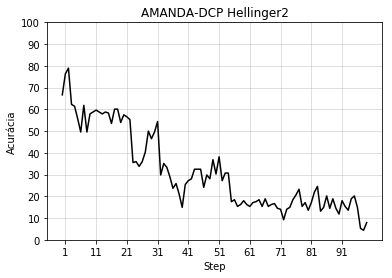

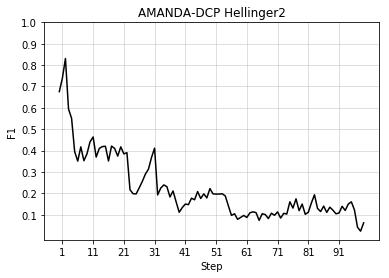




METHOD: lp as classifier and kde and BBD distance as dynamic CSE
AMANDA-DCP BBD - β = -1.000 | Mean keeping percentage=0.24 | Std keeping percentage=0.14
Execution time:  0.9158317194216465
Average error: 75.6401
Average macro-F1: 0.1656184057454765
Average micro-F1: 0.2411000000000001
Acurácia Média:  24.359899999999996
Desvio Padrão:  22.678048085979537
Variância:  514.2938649900001


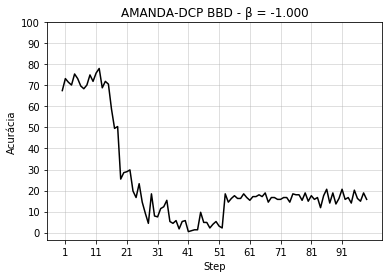

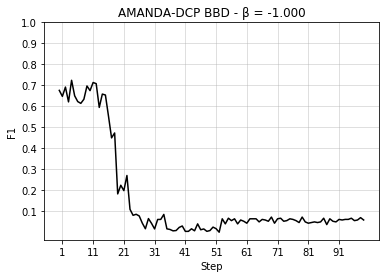

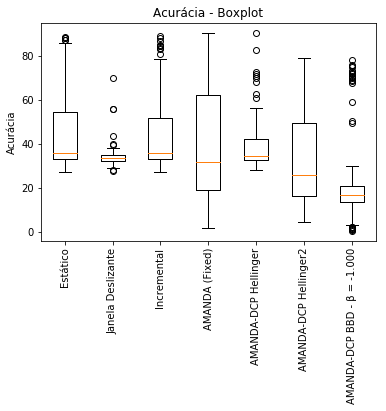

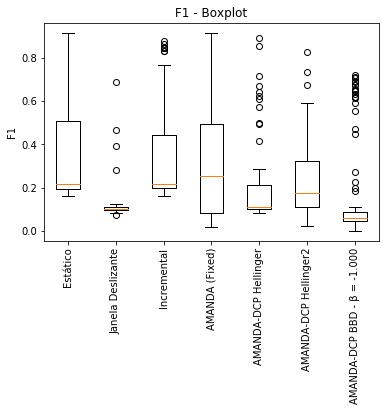

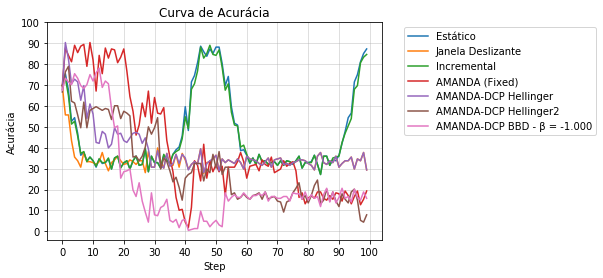

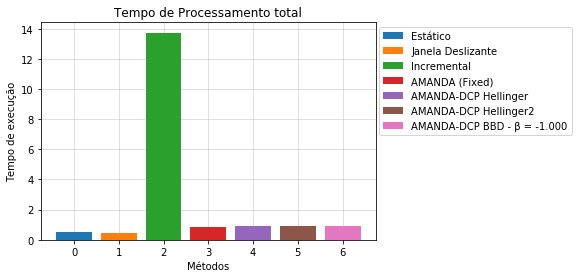

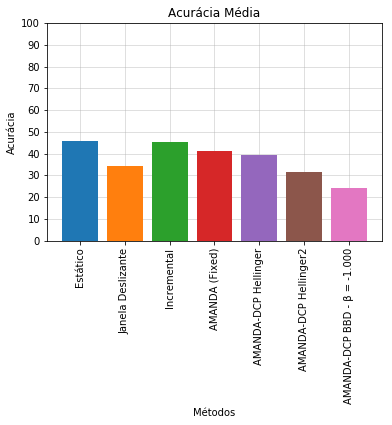

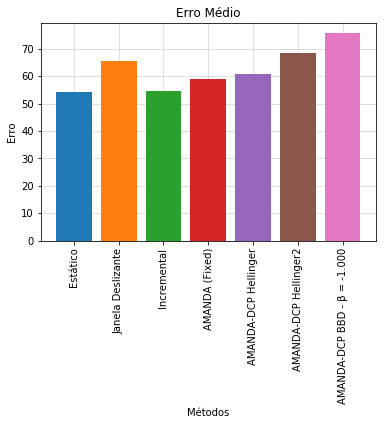

Pos 5 - Redução do Erro (Janela Deslizante):-25.12975098296202
Pos 2 - Redução do Erro (Incremental):-1.2271734381826394
Pos 3 - Redução do Erro (AMANDA (Fixed)):-10.181738750546092
Pos 4 - Redução do Erro (AMANDA-DCP Hellinger):-14.235474006116231
Pos 6 - Redução do Erro (AMANDA-DCP Hellinger2):-31.509392747924853
Pos 7 - Redução do Erro (AMANDA-DCP BBD - β = -1.000):-46.78920926168634


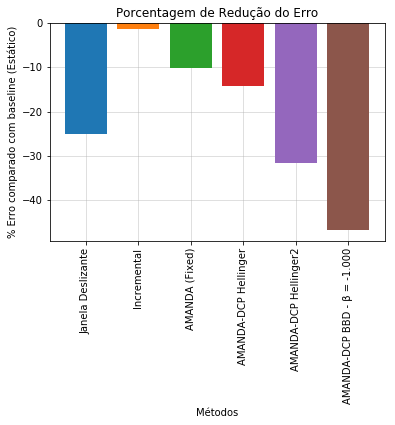

In [1]:
%matplotlib inline
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[4])

import setup
from methods import runExperiments
from methods import static_classifier
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import compose_gmm_version


class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None, distanceMetric=None, beta=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K
        self.distanceMetric = distanceMetric
        self.beta = beta


def loadLevelResults(path, sep, key, steps):
    originalAccs, F1s, time = setup.loadLevelIwBoxplotResults(path, sep)
    predictions = F1s[key]
    predictions = [ predictions[i::steps] for i in range(steps) ]
    
    return predictions, originalAccs[key], time[key]


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    # SETTINGS
    sslClassifier = 'lp' # lp = label propagation, rf = random forests, cl = cluster and label, knn = k-nn, svm = svm
    steps = 100
    poolSize = None
    isBatchMode = True # False = Stream
    isBinaryClassification = False
    isImbalanced = False
    externalResults = []
    
    # Load dataset
    dataValues, dataLabels, description = setup.load5CVT(path, sep)
    
    # 5% of initial labeled data
    labeledData = int(0.05*len(dataLabels))

    # Static SSL
    experiments[0] = Experiment(static_classifier, 8, clfName=sslClassifier)
    
    # Sliding SSL
    experiments[1] = Experiment(deslizante_LN, 8, clfName=sslClassifier)
    
    # Incremental SSL
    experiments[2] = Experiment(incremental_LN, 8, clfName=sslClassifier)
    
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    experiments[3] = Experiment(amanda_fixed, 8, 0.9, "kde", sslClassifier)

    # Proposed method 2 (AMANDA - DCP Original)
    experiments[4] = Experiment(amanda_dynamic, 7, None, "kde", sslClassifier, 'Hellinger')
    
    # Proposed method 3 (AMANDA - DCP Hellinger2)
    experiments[5] = Experiment(amanda_dynamic, 5, None, "kde", sslClassifier, 'Hellinger2')                         
    
    # Proposed method 4 (AMANDA - DCP BBD)
    lastIndex = list(experiments.keys())[-1]
    betas = [-1]
    bestK = [10]
    
    for i in range(len(betas)):
        experiments[lastIndex+1+i] = Experiment(amanda_dynamic, bestK[i], None, "kde", sslClassifier, 'BBD', beta=betas[i])
    
    # Proposed method 5 (AMANDA - DCP HDDDM)
    #experiments[17] = Experiment(amanda_dynamic, 8, None, "kde", sslClassifier, 'HDDDM')


    # COMPOSE GMM (Python version)
    #experiments[5] = Experiment(compose_gmm_version, 8)
    
    # levelIw matlab results
    #predictionsLevelIw, originalAccsLevelIw, timeLevelIw = loadLevelResults(path, sep, '5CVT', steps)
    #externalResults.append({"name":"Level IW", "predictions":predictionsLevelIw, "accuracies":originalAccsLevelIw, "time":timeLevelIw})
    
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)
    

if __name__ == "__main__":
    main()